In [17]:
from pathlib import Path
import re
from collections import Counter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Path to your local copy
# DATA_PATH = Path("data/raw/TinyStories/TinyStories-train.txt")
DATA_PATH = Path("..") / "data" / "raw" / "TinyStories" / "TinyStories-train.txt"


# Regular expression to recognize the <|endoftext|> delimiter
DELIM_RE = re.compile(r"\s*<\|endoftext\|\>\s*", flags=re.IGNORECASE)


In [5]:
# Rolling through the huge .txt file without loading it all into memory (doing 1MB at a time)

def stream_stories(path: Path, chunk_size: int = 1024 * 1024):
    """
    Yield one story at a time by splitting on <|endoftext|>.
    Reads in small chunks so we never hold the whole file in memory.
    """
    buf = ""
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            buf += chunk
            parts = DELIM_RE.split(buf)
            # all but the last are complete stories
            for s in parts[:-1]:
                s = s.strip()
                if s:
                    yield s
            buf = parts[-1]  # keep the tail for the next read
        # flush the remainder
        tail = buf.strip()
        if tail:
            yield tail


In [6]:
# Quick sanity checks through first 3 stories

for i, story in zip(range(3), stream_stories(DATA_PATH)):
    print(f"--- Story {i} ---")
    print(story[:400], "...\n")


--- Story 0 ---
One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.
Lily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."
Toge ...

--- Story 1 ---
Once upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.
One day, Beep was driving in the park when he saw a big tree. The tree had many leaves that were falling. Beep liked how the leaves fall and wanted to play with them. Beep drove under the tree and watched the l ...

--- Story 2 ---
One day, a little fish named Fin was swimming near the shore. He saw a big crab and wanted to be friends. "Hi, I am Fin. Do you want to play

In [15]:
def count_stories_with_byte_progress(path: Path, chunk_size: int = 1024 * 1024):
    total_bytes = path.stat().st_size
    count = 0
    buf = ""
    with path.open("r", encoding="utf-8", errors="ignore") as f, \
         tqdm(total=total_bytes, unit="B", unit_scale=True, desc="Reading file") as pbar:
        while True:
            chunk = f.read(chunk_size)
            if not chunk:
                break
            buf += chunk
            pbar.update(len(chunk))             # <- updates smoothly each chunk
            parts = DELIM_RE.split(buf)
            count += sum(1 for s in parts[:-1] if s.strip())
            buf = parts[-1]
        if buf.strip():
            count += 1
    return count

story_count = count_stories_with_byte_progress(DATA_PATH)
print(f"Total stories: {story_count:,}")

Reading file:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

Total stories: 2,119,489


In [18]:
# Counting <|endoftext|> markers in the file to check for integrity

def count_delims(path: Path, needle="<|endoftext|>"):
    total = 0
    with path.open("r", encoding="utf-8", errors="ignore") as f:
        for chunk in iter(lambda: f.read(1024 * 1024), ""):
            total += chunk.lower().count(needle)
    return total

raw_delims = count_delims(DATA_PATH)
print(f"Raw <|endoftext|> markers: {raw_delims:,}")


Raw <|endoftext|> markers: 2,119,697


In [19]:
# strip quotes/punctuation then grab the first alphabetical word
FIRST_WORD_RE = re.compile(r"^[\s\"'\-–—\(\[\{]*([A-Za-z]+)")

def first_word(text: str) -> str | None:
    m = FIRST_WORD_RE.match(text)
    if not m:
        return None
    return m.group(1).lower()


In [20]:
first_word_counts = Counter()
for story in tqdm(stream_stories(DATA_PATH), desc="Counting first words"):
    w = first_word(story)
    if w:
        first_word_counts[w] += 1

len(first_word_counts), sum(first_word_counts.values())


Counting first words: 0it [00:00, ?it/s]

(2880, 2119416)

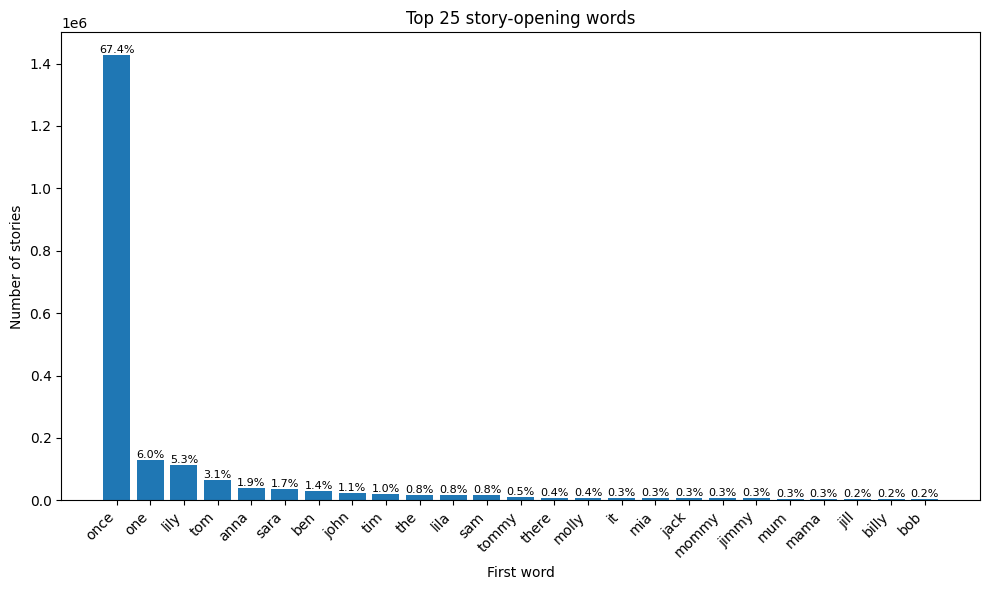

In [22]:
TOP_N = 25  # number of bars to plot in First Word barplot
top_items = first_word_counts.most_common(TOP_N)

words  = [w for w, c in top_items]
counts = [c for w, c in top_items]

total_stories = sum(first_word_counts.values())
percentages = [c / total_stories * 100 for c in counts]

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(words)), counts)
plt.xticks(range(len(words)), words, rotation=45, ha="right")
plt.title(f"Top {TOP_N} story-opening words")
plt.xlabel("First word")
plt.ylabel("Number of stories")

# annotate each bar with its percentage
for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{pct:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()


In [23]:
word_counts = []
for story in tqdm(stream_stories(DATA_PATH), desc="Counting words per story"):
    # simple split on whitespace; fine for TinyStories
    n_words = len(story.split())
    word_counts.append(n_words)

print(f"Processed {len(word_counts):,} stories.")
print(f"Shortest: {min(word_counts)} words, longest: {max(word_counts)} words")

Counting words per story: 0it [00:00, ?it/s]

Processed 2,119,489 stories.
Shortest: 5 words, longest: 963 words


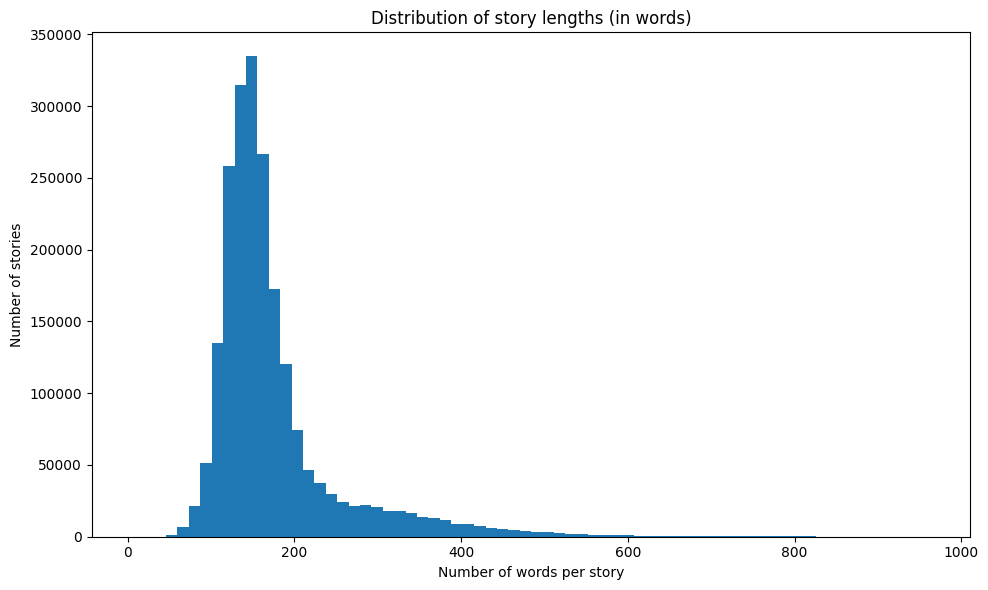

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(word_counts, bins=70)  # specify how many bins
plt.title("Distribution of story lengths (in words)")
plt.xlabel("Number of words per story")
plt.ylabel("Number of stories")
plt.tight_layout()
plt.show()
